# Classification Models
Chien-Lan Hsueh

Process:
1. Read the data in
2. Split the data into a training and test set
3. For each model type, use cross-validation on the training set to select a **best** model 
    - MLR models with logistic regression
    - Classification tree model 
    - Random forest model
4. Compare the best models on the test set and determine which the model has the lowest error

## 0. Preparation
Load needed modules.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# load all the functions we'll need from `sklearn`
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error

## 1. Read in the `diamonds` data set
Data source: from [kaggle](https://www.kaggle.com/datasets/shivam2503/diamondshttps://www.kaggle.com/datasets/shivam2503/diamonds).

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


None

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


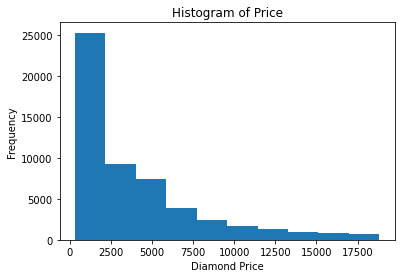

In [2]:
# read in data
df_raw = pd.read_csv("diamonds.csv")

# check the data
display(df_raw.info())
display(df_raw.head())

# plot a histogram of price
df_raw['price'].plot.hist()
plt.title("Histogram of Price")
plt.xlabel("Diamond Price")
plt.show()

Prepare the data:
- Based on the summaries and the plot above, I pick $5000 as a threshold to classify if a dimond is expensive or not.
- Create dummy variables for categorical variable `cut`, `color` and `price_group`
- Remove the `clarity` (to match the notebook in the lecture) and any other variables not being used in the modeling 

In [3]:
# set the price threshold 
price_threshold = 5000

# create dummy variable for categorical variables and remove variables which will not be used in the following modeling
df = df_raw \
    .assign(isExpensive = (df_raw['price'] > price_threshold).astype("int64")) \
    .join(pd.get_dummies(df_raw['cut'])) \
    .join(pd.get_dummies(df_raw['color'])) \
    .drop(['Unnamed: 0', 'price', 'cut', 'color', 'clarity'], axis = 1)

df.head()

,carat,depth,table,x,y,z,isExpensive,Fair,Good,Ideal,Premium,Very Good,D,E,F,G,H,I,J
0,0.23,61.5,55.0,3.95,3.98,2.43,0,0,0,1,0,0,0,1,0,0,0,0,0
1,0.21,59.8,61.0,3.89,3.84,2.31,0,0,0,0,1,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,4.05,4.07,2.31,0,0,1,0,0,0,0,1,0,0,0,0,0
3,0.29,62.4,58.0,4.20,4.23,2.63,0,0,0,0,1,0,0,0,0,0,0,1,0
4,0.31,63.3,58.0,4.34,4.35,2.75,0,0,1,0,0,0,0,0,0,0,0,0,1


Now let's check over the data to make sure the dummy variables aren't super rare. <br>
(Note: ideally we would explore the data more and consider transformations of variables and other feature engineering.)

In [4]:
# check the distribution of price for determing a cut and the dummy variables we just created
df.describe()

,carat,depth,table,x,y,z,isExpensive,Fair,Good,Ideal,Premium,Very Good,D,E,F,G,H,I,J
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,5.731157,5.734526,3.538734,0.272785,0.029848,0.090953,0.399537,0.255673,0.223990,0.125603,0.181628,0.176900,0.209344,0.153949,0.100519,0.052058
std,0.474011,1.432621,2.234491,1.121761,1.142135,0.705699,0.445395,0.170169,0.287545,0.489808,0.436243,0.416919,0.331404,0.385541,0.381588,0.406844,0.360903,0.300694,0.222146
min,0.200000,43.000000,43.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.700000,61.800000,57.000000,5.700000,5.710000,3.530000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.040000,62.500000,59.000000,6.540000,6.540000,4.040000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.010000,79.000000,95.000000,10.740000,58.900000,31.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 2. Training and Test Split
Create training and test splits:

In [5]:
# create a 80-20 training/test split 
X_train, X_test, y_train, y_test = train_test_split(
  df.drop('isExpensive', axis = 1),
  df['isExpensive'], 
  test_size = 0.20, 
  random_state = 42)

In [6]:
# Take a look at the splits - training set
display(X_train.shape)
display(X_train.head())
display(y_train.head())

# Take a look at the splits - test set
display(X_test.shape)
display(X_test.head())
display(y_test.head())

(43152, 18)

,carat,depth,table,x,y,z,Fair,Good,Ideal,Premium,Very Good,D,E,F,G,H,I,J
26546,2.01,58.1,64.0,8.23,8.19,4.77,0,1,0,0,0,0,0,1,0,0,0,0
9159,1.01,60.0,60.0,6.57,6.49,3.92,0,0,0,0,1,0,1,0,0,0,0,0
14131,1.10,62.5,58.0,6.59,6.54,4.10,0,0,0,1,0,0,0,0,0,1,0,0
15757,1.50,61.5,65.0,7.21,7.17,4.42,0,1,0,0,0,0,1,0,0,0,0,0
24632,1.52,62.1,57.0,7.27,7.32,4.53,0,0,0,0,1,0,0,0,1,0,0,0


26546    1
9159     0
14131    1
15757    1
24632    1
Name: isExpensive, dtype: int64

(10788, 18)

,carat,depth,table,x,y,z,Fair,Good,Ideal,Premium,Very Good,D,E,F,G,H,I,J
1388,0.24,62.1,56.0,3.97,4.00,2.47,0,0,1,0,0,0,0,0,1,0,0,0
50052,0.58,60.0,57.0,5.44,5.42,3.26,0,0,0,0,1,0,0,1,0,0,0,0
41645,0.40,62.1,55.0,4.76,4.74,2.95,0,0,1,0,0,0,1,0,0,0,0,0
42377,0.43,60.8,57.0,4.92,4.89,2.98,0,0,0,1,0,0,1,0,0,0,0,0
17244,1.55,62.3,55.0,7.44,7.37,4.61,0,0,1,0,0,0,1,0,0,0,0,0


1388     0
50052    0
41645    0
42377    0
17244    1
Name: isExpensive, dtype: int64

We have arranged the `X_train` and `X_test` data sets: 
- Numerical columns: the first **6** columns (0 - 5)
- Categorical columns : columns staring from column number **6** (6 - 17)

Therefore, we will define a constant to mark this column number so that we can specify numerical and categorical columns easily.

In [7]:
# categorical variables starting column
col_cat_starts = 6

## 3. Fit and Select Models on Training Data

### MLR Models
We will use cross validation on the training data to fit the following types of MLR models:
- Full model: both numeric and categorical (dummy) variables without interactions
- Numeric model: only numeric variables without interaction
- Dummy model: only categorical (dummy) variables without interaction
- Full interaction model: both numeric and categorical (dummy) variables with interactions
- Numerical interation model: only numeric variables with interaction

Note: I spearted the following code cells so that we can keep track on running time.

In [8]:
# Full model
cv_full_model = cross_validate(
    LogisticRegression(max_iter=10000), 
    X_train, 
    y_train, 
    cv = 5, 
    scoring = "neg_mean_squared_error")

In [9]:
# Numeric model
cv_numeric_model = cross_validate(
    LogisticRegression(max_iter=10000), 
    X_train[["carat", "depth", "table", "x", "y", "z"]], 
    y_train, 
    cv = 5,
    scoring = "neg_mean_squared_error")


In [10]:
# Dummy model (dummy variable only)
cv_dummy_model = cross_validate(
    LogisticRegression(max_iter=10000), 
    X_train.iloc[:, col_cat_starts:], 
    y_train, 
    cv = 5,
    scoring = "neg_mean_squared_error")


In [11]:
# Full interaction model
poly = PolynomialFeatures(interaction_only=True, include_bias = False)
cv_full_interaction_model = cross_validate(
    LogisticRegression(max_iter=10000), 
    poly.fit_transform(X_train), 
    y_train, 
    cv = 5,
    scoring = "neg_mean_squared_error")


In [12]:
# Numerical interation model
cv_numeric_interaction_model = cross_validate(
    LogisticRegression(max_iter=10000), 
    np.concatenate((poly.fit_transform(X_train[["carat", "depth", "table", "x", "y", "z"]]), X_train.iloc[:, col_cat_starts:].to_numpy()), axis = 1), 
    y_train, 
    cv = 5,
    scoring = "neg_mean_squared_error")


In [13]:
# compare the models
print(np.sqrt(-sum(cv_full_model['test_score'])), 
      np.sqrt(-sum(cv_numeric_model['test_score'])), 
      np.sqrt(-sum(cv_dummy_model['test_score'])), 
      np.sqrt(-sum(cv_full_interaction_model['test_score'])), 
      np.sqrt(-sum(cv_numeric_interaction_model['test_score']))) 

0.5898779184664054 0.6613677436920058 1.1725644751854103 0.5863313830586594 0.5849464162762452


Since full model, full interaction and numeric interaction model have simliar smallest MSE, we will pick the simplest model - the full model.

In [14]:
# fit with the best model
mlr_best = LogisticRegression(max_iter=10000).fit(X_train, y_train)

# print the intercept and coefficients
print(mlr_best .intercept_, mlr_best .coef_)

[-18.27200865] [[ 1.07474214e+01 -9.77341935e-04 -7.39923683e-02  1.07476655e+00
   5.52877891e-01  2.53146117e-01 -1.88742804e+00 -5.60638348e-01
   2.06538472e-01 -3.42670841e-01 -3.56285760e-02  8.31580365e-01
   5.45370455e-01  4.47978789e-01  5.58004509e-01 -6.93055642e-01
  -1.66383410e+00 -2.64587171e+00]]


We can use confusion matric and accuracy rate to see how good the model is:

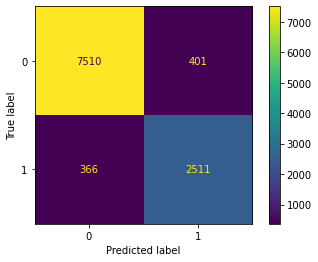

0: price is normal
1: price is expensive
The MSE is 0.26664117416154975 and the accuracy is 92.89%.


In [15]:
# predict on test data
pred_mlr_best = mlr_best.predict(X_test)

# compute accuracy
acc_mlr_best = np.mean(pred_mlr_best == y_test)

# compute mean squre error
mse_mlr_best = np.sqrt(mean_squared_error(y_test, pred_mlr_best))

# confuision matrix
cfm_mlr_best = confusion_matrix(y_test, pred_mlr_best, labels=[0, 1])

# plot confuision matrix
pcm_mlr_best = ConfusionMatrixDisplay(cfm_mlr_best).plot()
plt.show()
print(f"0: price is normal\n"
      f"1: price is expensive\n"
      f"The MSE is {mse_mlr_best} and the accuracy is {acc_mlr_best:.2%}.")

# save mse, accuracy and confusion matrix plot
lst_mlr_best = ["MLR", mse_mlr_best, acc_mlr_best, pcm_mlr_best]

### Classification Tree Model

In [16]:
# set up model parameters for tree classification modeling
parameters = {'max_depth': range(2,20),
              'min_samples_leaf':[10, 50, 100, 250]}

# use a grid serach to estimate the best classification tree model
tree_model = GridSearchCV(
    DecisionTreeClassifier(),
    parameters, 
    cv = 5, 
    scoring='neg_mean_squared_error') \
    .fit(X_train, y_train)
    
print(tree_model.best_estimator_)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=50)


Use cross validation with the best estimator tree model to compute the RMSE for comparison:

In [17]:
# use a cross validation to compute RMSE
ctree_cv = cross_validate(
    tree_model.best_estimator_,
    X_train,
    y_train,
    cv = 5,
    scoring='neg_mean_squared_error')

print(np.sqrt(-sum(ctree_cv['test_score'])))

0.5703031727050096


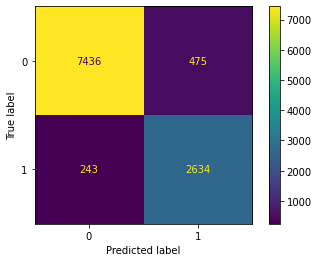

0: price is normal
1: price is expensive
The MSE is 0.25798339473973636 and the accuracy is 93.34%.


In [18]:
# fit with the best tree model
ctree_best = tree_model.best_estimator_.fit(X_train, y_train)

# predict on test data
pred_ctree_best = ctree_best.predict(X_test)

# compute mean squre error
mse_ctree_best = np.sqrt(mean_squared_error(y_test, pred_ctree_best))

# compute accuracy
acc_ctree_best = np.mean(pred_ctree_best == y_test)

# confuision matrix
cfm_ctree_best = confusion_matrix(y_test, pred_ctree_best, labels=[0, 1])

# plot confuision matrix
pcm_ctree_best = ConfusionMatrixDisplay(cfm_ctree_best).plot()
plt.show()
print(f"0: price is normal\n"
      f"1: price is expensive\n"
      f"The MSE is {mse_ctree_best} and the accuracy is {acc_ctree_best:.2%}.")

# save mse, accuracy and confusion matrix plot
lst_ctree_best = ["Classification tree", mse_ctree_best, acc_ctree_best, pcm_ctree_best]

### Random Forest Model (Includes Bagged Tree as a Special Case)

<font color = "red">Warning: the next cell will run for a longer time (~22.5 mins on my PC).</font>

In [19]:
# set up model parameters for tree classification modeling
parameters = {"max_features" : range(1, X_train.shape[1])}

# use a grid serach to estimate the best random forest model
rf_tune = GridSearchCV(
    RandomForestClassifier(n_estimators = 500),
    parameters,
    cv = 5,
    scoring='neg_mean_squared_error') \
    .fit(X_train, y_train)

print(rf_tune.best_estimator_)

RandomForestClassifier(max_features=11, n_estimators=500)


Use cross validation with the best estimator random forest model to compute the RMSE for comparison:

In [20]:
# use a cross validation to compute RMSE
rf_cv = cross_validate(rf_tune.best_estimator_,
                       X_train,
                       y_train,
                       cv = 5,
                       scoring='neg_mean_squared_error')

print(np.sqrt(-sum(rf_cv['test_score'])))

0.5653036975895163


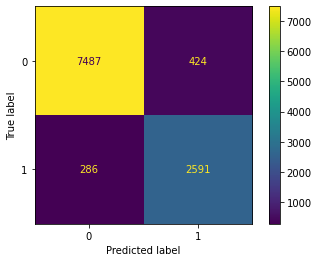

0: price is normal
1: price is expensive
The MSE is 0.2565421354474123 and the accuracy is 93.42%.


In [21]:
# fit with the best random forest model
rf_best = rf_tune.best_estimator_.fit(X_train, y_train)

# predict on test data
pred_rf_best = rf_best.predict(X_test)

# compute mean squre error
mse_rf_best = np.sqrt(mean_squared_error(y_test, pred_rf_best))

# compute accuracy
acc_rf_best = np.mean(pred_rf_best == y_test)

# confuision matrix
cfm_rf_best = confusion_matrix(y_test, pred_rf_best, labels=[0, 1])

# plot confuision matrix
pcm_rf_best = ConfusionMatrixDisplay(cfm_rf_best).plot()
plt.show()
print(f"0: price is normal\n"
      f"1: price is expensive\n"
      f"The MSE is {mse_rf_best} and the accuracy is {acc_rf_best:.2%}.")

# save mse, accuracy and confusion matrix plot
lst_rf_best = ["Random Forest", mse_rf_best, acc_rf_best, pcm_rf_best]

## 4. Compare on the Test Set

MLR model: MSE = 0.26664117416154975 and accuracy =92.89%.


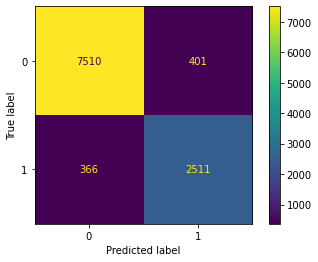

Classification tree model: MSE = 0.25798339473973636 and accuracy =93.34%.


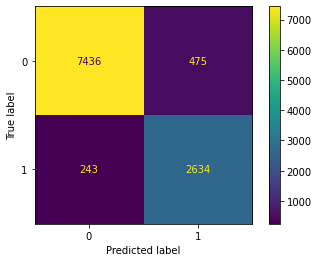

Random Forest model: MSE = 0.2565421354474123 and accuracy =93.42%.


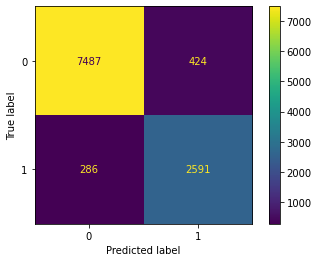

In [22]:
for _ in [lst_mlr_best , lst_ctree_best , lst_rf_best]:
    print(f"{_[0]} model: MSE = {_[1]} and accuracy ={_[2]:.2%}.")
    _[3].plot()
    plt.show()

Based on the comparison above, Random Forest performs slightly better than the other two models on the test set.